In [67]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import openpyxl

#Import pipeline functions
import recist_and_volume_calculator as rc


In [68]:
#lets open a test image
path = '/Users/constance/Documents/Project_lung_cancer/NIH dataset_raw/Processed/Lung_Dx-A0002_(DL)'
image = sitk.ReadImage(os.path.join(path,'image.nrrd'))
spacing = image.GetSpacing()
image_array = sitk.GetArrayFromImage(image)
dl_mask_array = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(path,'DL_mask.nrrd')))

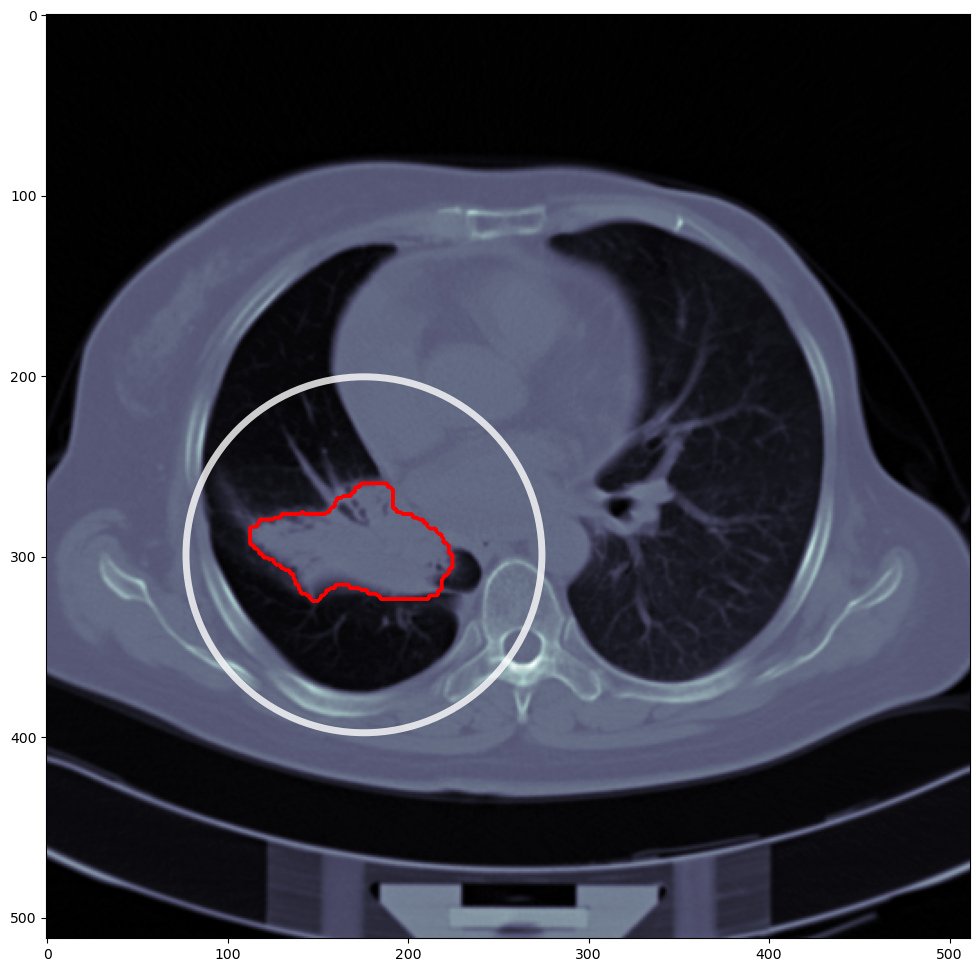

----------------------------------------
Predicted RECIST: 73 mm
Predicted tumor volume: 60.01 ml
----------------------------------------


In [69]:
##Calculate metrics
recist_predicted,volume_predicted,idx,circle = rc.calculate_values(dl_mask_array,spacing)
circle1 = plt.Circle((circle[1], circle[0]), circle[2]*2, color='white',fill=False,alpha=0.8, lw=5)

plt.figure(figsize=(12,12))
plt.imshow(image_array[idx,...],cmap='bone')
plt.contour(dl_mask_array[idx,...],colors='r')
fig = plt.gcf()
ax = fig.gca()
ax.add_patch(circle1)
plt.show()

print('-'*40)
print('Predicted RECIST: %s mm'%recist_predicted) 
print('Predicted tumor volume: %s ml'%volume_predicted)
print('-'*40)

In [70]:
# Module pour calculer les métriques RECIST (diamètre maximal) et volume
class RecistCalculator:
    @staticmethod
    def calculate_values(mask_array, spacing):
        """
        Calcule le diamètre RECIST et le volume de la tumeur à partir d'un masque 3D
        
        Args:
            mask_array: Array numpy 3D du masque de segmentation
            spacing: Espacement des voxels (x, y, z)
            
        Returns:
            recist: Diamètre maximal en mm
            volume: Volume tumoral en ml
            idx: Index de la coupe avec le plus grand diamètre
            circle: Coordonnées du cercle (y, x, r)
        """
        # Trouver l'index de la coupe avec la plus grande surface tumorale
        areas = [np.sum(mask_array[i,...]) for i in range(mask_array.shape[0])]
        idx = np.argmax(areas)
        
        # Obtenir la coupe avec la plus grande surface tumorale
        tumor_slice = mask_array[idx,...].astype(np.uint8)
        
        # Si la tumeur n'est pas présente sur cette coupe, retourner 0
        if np.sum(tumor_slice) == 0:
            return 0, 0, idx, (0, 0, 0)
        
        # Calculer les propriétés de la région
        # Trouver les points extrêmes de la tumeur
        points = np.argwhere(tumor_slice > 0)
        if len(points) < 2:
            return 0, 0, idx, (0, 0, 0)
            
        # Calculer toutes les distances entre les points
        from scipy.spatial.distance import pdist
        distances = pdist(points)
        max_dist = np.max(distances)
        
        # Convertir en mm en utilisant l'espacement
        recist = max_dist * spacing[0]  # mm
        
        # Calculer le volume en ml (1 ml = 1000 mm³)
        voxel_volume = spacing[0] * spacing[1] * spacing[2]  # mm³
        volume = np.sum(mask_array) * voxel_volume / 1000  # ml
        
        # Trouver les points extrêmes pour dessiner un cercle
        # Pour simplifier, nous utilisons un cercle basé sur le centre de masse et le rayon max
        y_indices, x_indices = np.where(tumor_slice > 0)
        center_y = np.mean(y_indices)
        center_x = np.mean(x_indices)
        
        # Calculer le rayon approximatif (diamètre / 2)
        radius = max_dist / 2
        
        circle = (center_y, center_x, radius)
        
        return recist, volume, idx, circle

def process_patient_folder(folder_path, recist_calculator):
    """
    Traite un dossier patient et extrait les métriques de la tumeur
    
    Args:
        folder_path: Chemin vers le dossier du patient
        recist_calculator: Instance de RecistCalculator
        
    Returns:
        dict: Dictionnaire contenant les métriques du patient
    """
    try:
        # Extraire l'ID du patient à partir du nom du dossier
        patient_id = os.path.basename(folder_path)
        
        # Vérifier si les fichiers nécessaires existent
        image_path = os.path.join(folder_path, 'image.nrrd')
        mask_path = os.path.join(folder_path, 'DL_mask.nrrd')
        
        if not os.path.exists(image_path) or not os.path.exists(mask_path):
            print(f"Fichiers manquants pour le patient {patient_id}")
            return None
        
        # Charger les images
        image = sitk.ReadImage(image_path)
        spacing = image.GetSpacing()
        image_array = sitk.GetArrayFromImage(image)
        mask_array = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))
        
        # Calculer les métriques
        recist, volume, idx, circle = recist_calculator.calculate_values(mask_array, spacing)
        
        # Retourner les résultats
        return {
            'patient_id': patient_id,
            'recist_mm': recist,
            'volume_ml': volume,
            'slice_index': idx
        }
    except Exception as e:
        print(f"Erreur lors du traitement du patient {os.path.basename(folder_path)}: {str(e)}")
        return None

def scan_directory(base_directory, output_csv):
    """
    Parcourt un répertoire contenant des dossiers patients et stocke les métriques tumorales
    
    Args:
        base_directory: Répertoire contenant les dossiers patients
        output_csv: Chemin du fichier CSV de sortie
    """
    # Créer une instance du calculateur RECIST
    recist_calculator = RecistCalculator()
    
    # Liste pour stocker les résultats
    results = []
    
    # Parcourir tous les sous-dossiers (un par patient)
    for item in os.listdir(base_directory):
        folder_path = os.path.join(base_directory, item)
        
        # Vérifier si c'est un dossier
        if os.path.isdir(folder_path):
            print(f"Traitement du patient: {item}")
            patient_data = process_patient_folder(folder_path, recist_calculator)
            
            if patient_data:
                results.append(patient_data)
    
    # Créer un DataFrame et l'exporter en CSV
    if results:
        df = pd.DataFrame(results)
        df.to_csv(output_csv, index=False)
        print(f"Résultats enregistrés dans {output_csv}")
        print(f"Nombre total de patients traités: {len(results)}")
        return df
    else:
        print("Aucun résultat trouvé.")
        return None

def visualize_patient(folder_path):
    """
    Visualise les images et segmentations d'un patient spécifique
    
    Args:
        folder_path: Chemin vers le dossier du patient
    """
    try:
        # Charger les images
        image = sitk.ReadImage(os.path.join(folder_path, 'image.nrrd'))
        spacing = image.GetSpacing()
        image_array = sitk.GetArrayFromImage(image)
        mask_array = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(folder_path, 'DL_mask.nrrd')))
        
        # Calculer les métriques
        recist_calculator = RecistCalculator()
        recist, volume, idx, circle = recist_calculator.calculate_values(mask_array, spacing)
        
        # Afficher l'image avec la segmentation et le diamètre RECIST
        circle1 = plt.Circle((circle[1], circle[0]), circle[2], color='white', fill=False, alpha=0.8, lw=2)
        
        plt.figure(figsize=(12, 12))
        plt.imshow(image_array[idx,...], cmap='bone')
        plt.contour(mask_array[idx,...], colors='r')
        fig = plt.gcf()
        ax = fig.gca()
        ax.add_patch(circle1)
        plt.title(f"Patient: {os.path.basename(folder_path)}")
        plt.show()
        
        print('-' * 40)
        print(f'Patient ID: {os.path.basename(folder_path)}')
        print(f'RECIST: {recist:.2f} mm')
        print(f'Volume tumoral: {volume:.2f} ml')
        print('-' * 40)
        
    except Exception as e:
        print(f"Erreur lors de la visualisation: {str(e)}")



In [71]:
# Répertoire de base contenant les dossiers patients
base_dir = '/Users/constance/Documents/Project_lung_cancer/NIH dataset_raw/Processed'
output_file = 'resultats_tumeurs.csv'

# Scanner tous les patients et créer un CSV
results_df = scan_directory(base_dir, output_file)
print(results_df)

Traitement du patient: Lung_Dx-A0056_(DL)
Traitement du patient: Lung_Dx-A0051_(DL)
Traitement du patient: Lung_Dx-A0005_(DL)
Traitement du patient: Lung_Dx-A0033_(DL)
Traitement du patient: 04-04-2007-NA-Chest-07990_(DL)
Traitement du patient: Lung_Dx-A0058_(DL)
Traitement du patient: Lung_Dx-A0002_(DL)
Traitement du patient: Lung_Dx-A0034_(DL)
Résultats enregistrés dans resultats_tumeurs.csv
Nombre total de patients traités: 8
                       patient_id   recist_mm   volume_ml  slice_index
0              Lung_Dx-A0056_(DL)   59.309000   45.110299           11
1              Lung_Dx-A0051_(DL)  104.366557  182.085432           20
2              Lung_Dx-A0005_(DL)    0.000000    0.000000            0
3              Lung_Dx-A0033_(DL)   25.859336    3.781102           20
4  04-04-2007-NA-Chest-07990_(DL)   56.500814   61.883957           44
5              Lung_Dx-A0058_(DL)   30.817416    7.406873          103
6              Lung_Dx-A0002_(DL)   73.155642   60.006447           15

In [72]:
# Charger les données cliniques
clinical_data = pd.read_excel('/Users/constance/Documents/Project_lung_cancer/NIH dataset_raw/statistics-clinical-20201221.xlsx')

# Fonction pour extraire l'ID dans le format A0056 à partir de strings comme "Lung_Dx-A0056_(DL)"
def extract_subject_id(id_string):
    if isinstance(id_string, str):
        # Recherche du pattern A suivi de chiffres
        match = re.search(r'A\d+', id_string)
        if match:
            return match.group(0)
    return None

# Ajout d'une colonne avec l'ID extrait dans le format uniforme
results_df['NewPatientID'] = results_df['patient_id'].apply(extract_subject_id)

# Sélectionner seulement les données T-stage du dataframe clinique
t_stage_data = clinical_data[['NewPatientID', 'T-Stage']]

# Merger les deux dataframes sur la colonne subject_id
combined_data = pd.merge(
    results_df[['NewPatientID', 'recist_mm']], 
    t_stage_data,
    on='NewPatientID',
    how='inner'  # pour ne garder que les correspondances
)

# Afficher le résultat final
print("\nCombined data (T-stage et RECIST size):")
print(combined_data)

# Sauvegarder les données combinées
combined_data.to_csv('combined_t_stage_recist.csv', index=False)


Combined data (T-stage et RECIST size):
  NewPatientID   recist_mm T-Stage
0        A0056   59.309000       3
1        A0051  104.366557       4
2        A0005    0.000000      1b
3        A0033   25.859336      1c
4        A0058   30.817416      1c
5        A0002   73.155642      2b
6        A0034   69.062420       3


In [73]:
# Stage ranking to map T-stage to a numerical scale
stage_order = {
    'unknown': 0,
    '1a': 1,
    '1b': 2,
    '1c': 3,
    '2a': 4,
    '2b': 5,
    '3': 6,
    '4': 7
}

# Function to determine correct T-stage from RECIST size
def get_correct_t_stage(size_mm):
    if size_mm == 0:
        return 'unknown'
    elif size_mm <= 10:
        return '1a'
    elif size_mm <= 20:
        return '1b'
    elif size_mm <= 30:
        return '1c'
    elif size_mm <= 40:
        return '2a'
    elif size_mm <= 50:
        return '2b'
    elif size_mm <= 70:
        return '3'
    else:
        return '4'

# Apply function to compute correct T-stage
combined_data['Model_T-Stage'] = combined_data['recist_mm'].apply(get_correct_t_stage)

# Normalize both T-stage values to lowercase strings
combined_data['Normalized_T-Stage'] = combined_data['T-Stage'].astype(str).str.lower()

# Compare with existing T-stage
combined_data['Match'] = combined_data['Normalized_T-Stage'] == combined_data['Model_T-Stage']

# Output results
print("Full Verification Table:")
print(combined_data)


Full Verification Table:
  NewPatientID   recist_mm T-Stage Model_T-Stage Normalized_T-Stage  Match
0        A0056   59.309000       3             3                  3   True
1        A0051  104.366557       4             4                  4   True
2        A0005    0.000000      1b       unknown                 1b  False
3        A0033   25.859336      1c            1c                 1c   True
4        A0058   30.817416      1c            2a                 1c  False
5        A0002   73.155642      2b             4                 2b  False
6        A0034   69.062420       3             3                  3   True


In [74]:

# Compute numeric error where there is a mismatch
def compute_error(row):
    if not row['Match']:
        actual = stage_order.get(row['Normalized_T-Stage'], -1)
        correct = stage_order.get(row['Model_T-Stage'], -1)
        return abs(actual - correct)
    else:
        return 0
    
combined_data['Stage_Error'] = combined_data.apply(compute_error, axis=1)

# Show mismatches
mismatches = combined_data[combined_data['Match'] == False]

# Output results
print("Full Verification Table:")
print(combined_data)

print("\nMismatches:")
print(mismatches[['recist_mm', 'T-Stage', 'Model_T-Stage', 'Stage_Error']])

Full Verification Table:
  NewPatientID   recist_mm T-Stage Model_T-Stage Normalized_T-Stage  Match  \
0        A0056   59.309000       3             3                  3   True   
1        A0051  104.366557       4             4                  4   True   
2        A0005    0.000000      1b       unknown                 1b  False   
3        A0033   25.859336      1c            1c                 1c   True   
4        A0058   30.817416      1c            2a                 1c  False   
5        A0002   73.155642      2b             4                 2b  False   
6        A0034   69.062420       3             3                  3   True   

   Stage_Error  
0            0  
1            0  
2            2  
3            0  
4            1  
5            2  
6            0  

Mismatches:
   recist_mm T-Stage Model_T-Stage  Stage_Error
2   0.000000      1b       unknown            2
4  30.817416      1c            2a            1
5  73.155642      2b             4            2
